Model-driven strategies have long been the classic framework to address the derivation of governing equations. However, the ever increasing availability of large-scale observation and simulation datasets makes more and more appealing the development of data-driven strategies especially when dealing with computationally-demanding models or phenomenons with high modeling uncertainties. 

The use of a given identification scheme is strongly conditioned by the nature of the provided observations. In this context, let us start by introducing the following state space model formulation

\begin{equation}
\left \{
\begin{array}{ccl}
\dot{{z}_{t}} &= {f}({z}_{t}, \eta_t)\\
{x}_{t} &= \mathcal{H}({z}_{t},\epsilon_{t})
\label{eq:C10_SSM}
\end{array}\right.
\end{equation}

where $z \in \mathbb{R}^{s}$ and $x \in \mathbb{R}^{n}$ represent the hidden state variables and the observations respectively, $f$ and $\mathcal{H}$ the dynamical and observation models. $\eta_t$ and $\epsilon_{t}$ are random process accounting for the uncertainties in the dynamical and observation models respectively. 

In an identification scenario, neither the dynamical model $f_{\theta}$, nor the state variables ${z}$ are known. Instead, we are only provided with the observations ${x}$ that are related in some way to the hidden states through the observation operator $\mathcal{H}$ and the noise $\epsilon$. Furthermore, the dynamical model noise $\eta_t$ can account for either i) errors in modeling a deterministic real phenomenon or ii) stochastic variability of the data. In the latter case, deterministic modeling techniques can only express the variability of the mean component and stochastic identification techniques need to be used. In this work however, we mostly focus on deterministic representations and we assume for the rest of this section that the noise $\eta$ can be neglected i.e. $\eta = 0$. 

Depending on the nature of the observation operator $\mathcal{H}$ and the noise $\epsilon$, several data-driven schemes could be considered. In this context, this notebook we will introduce a some considerations regarding the provided observations and the corresponding identification technique.

# 1) Data generation

In [1]:
!pip install torchdiffeq

In [56]:
from Generate_data import generate_data
import numpy as np
import matplotlib.pyplot as plt
import torch
from scipy.integrate import odeint
from tqdm import tqdm

In [3]:
# dataset parameters
class GD:
    model = 'Lorenz_63'
    class parameters:
        sigma = 10.0
        rho = 28.0
        beta = 8.0/3
    dt_integration = 0.01 # sampling time
    nb_loop_train = 100.01 #7500.1 # size of the catalog
    nb_loop_test = 100 # size of the true state and noisy observations
    sigma2_catalog = 0.0 # variance of the model error to generate the catalog
    
# run the data generation
catalog, xt = generate_data(GD)
# catalog is the true states zt, it containts a time sliced data base : 
# catalog.analogs    == zt
# catalog.successors == zt+n*dt_integration
# xt is the test set

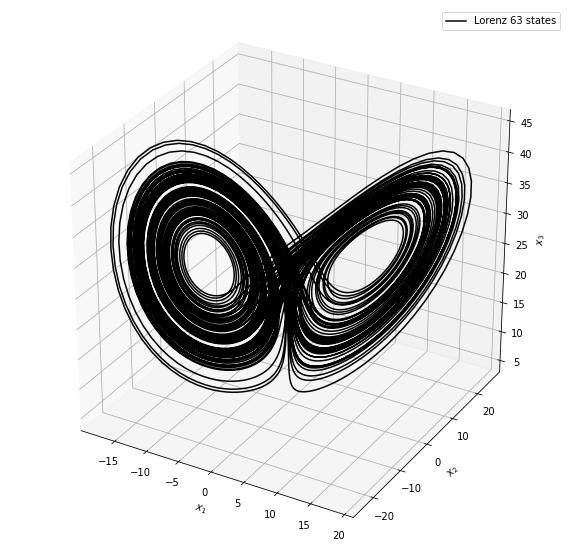

In [4]:
# plot
fig=plt.figure(figsize=(10,10))
ax=fig.gca(projection='3d')
line1,=ax.plot(catalog.analogs[:,0],catalog.analogs[:,1],catalog.analogs[:,2],'k')
ax.set_xlabel('$x_1$');ax.set_ylabel('$x_2$');ax.set_zlabel('$x_3$')
plt.legend([line1], ['Lorenz 63 states'])

When provided with direct measurements of the state vector ${z}$ (typically when the observation operator $\mathcal{H}$ is the identity matrix and the observation noise $\epsilon$ is zero), the problem may be regarded as the identification of the most appropriate basis function that will explain the temporal variability of the observations. Formally, the above state space model can be rewritten as follows:
\begin{equation}
\left \{
\begin{array}{ccl}
\dot{{z}_{t}} &= {f_{\theta}}({z}_{t})\\
{x}_{t} &= {z}_{t}
\label{eq:C2_dm_SSM_identity}
\end{array}\right.
\end{equation}

In this scenario, and given an approximation $f_{\theta}$ of the underlying dynamical function $f$, a data driven representation typically aims at minimizing a forecasting cost of the following form:
\begin{equation}
    \displaystyle \min_{\theta} \sum_{n=1}^N \| {z}_{t_{n}} - \Phi_{\theta,t_n}({z}_{t_{n-1}})\| 
    \label{eq:opti_case_Identity}
\end{equation}
where $\Phi_{\theta,t_n}({z}_{t_{n-1}}) = {z}_{t_{n-1}} + \int_{t_{n-1}}^{t_n}f_{\theta}({z}_{w})dw$.

Or, in a differential form : 
\begin{equation}
    \displaystyle \min_{\theta} \sum_{n=1}^N \| \dot{{z}_{t}} - {f_{\theta}}({z}_{t})\| 
\end{equation}

where $\dot{{z}_{t}}$ is estimated from data.

# 2) Dictionary based linear regression
## 2.1) Linear model

A first category of identification methods involves global parametric representations derived from physical principles where polynomial representations are typical examples. In the following we consider the identification of a dynamical system using linear regression i.e. $f_{\theta} = A$ where A is a matrix. For this purpose we use the SINDy library of (Steven L. Brunton et al. 2016)

In [5]:
from SINDy import *

In [6]:
t_data       = np.arange(0,catalog.analogs.shape[0],1)*GD.dt_integration # needed in SINDy
data         = np.transpose(np.insert(np.array([catalog.analogs[:,0] , catalog.analogs[:,1] , catalog.analogs[:,2]]),0,t_data,axis=0))
ddata        = np.zeros([catalog.analogs.shape[0],catalog.analogs.shape[-1]+1])
ddata[:,1:]  = np.gradient(data[:,1:])[0]/GD.dt_integration

# Here sparsity_itterations is set to 0 to mimic a classical least square optimization
# Polyorder  = 1 : Linear model
sin = SINDy(data=data,polyorder=1,usesine=False,cutoff=0.02, sparsity_itterations = 0)
sin.SetDerivative(ddata)
sin.RunSINDy(simulate=False)

def Identified_Model(y,t, sin) :
    y=np.reshape(y,(1,y.shape[-1]))
    aug=sin.PoolData(y)    
    dy = np.dot(aug,sin._xi)
    return np.reshape(dy,(y.shape[-1]))

Initiated a class for Sparse Identification from Numerical Dynamics
**** Derivative Set ****
**** Candidate functions library has been created ****
**** Performing regression. Please wait... ****
Iteration in progress: 



In [7]:
init_cond   = xt.values[0,:]
end_time    = 10
S_lin_Model = odeint(Identified_Model,init_cond,np.arange(0.01,end_time+0.000001,GD.dt_integration),args=(sin,)); 

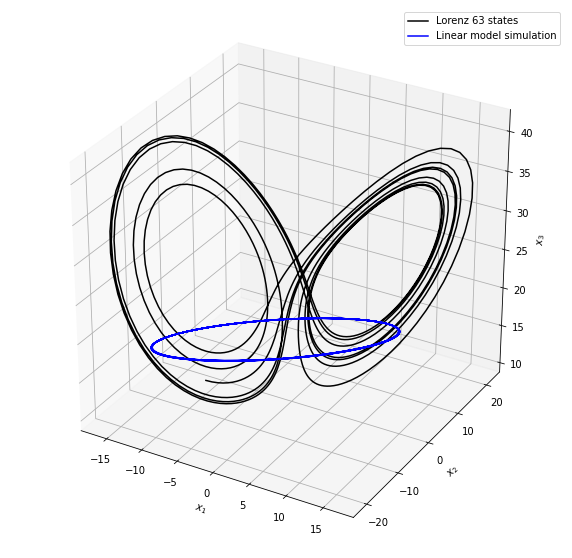

In [8]:
# plot
fig=plt.figure(figsize=(10,10))
ax=fig.gca(projection='3d')
line1,=ax.plot(xt.values[:1000,0],xt.values[:1000,1],xt.values[:1000,2],'k')
line2,=ax.plot(S_lin_Model[:1000,0],S_lin_Model[:1000,1],S_lin_Model[:1000,2],'b')
ax.set_xlabel('$x_1$');ax.set_ylabel('$x_2$');ax.set_zlabel('$x_3$')
plt.legend([line1,line2], ['Lorenz 63 states', 'Linear model simulation'])

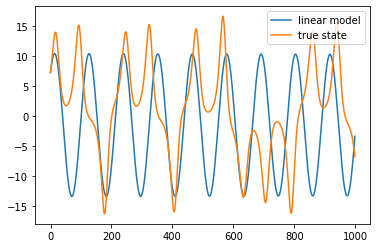

In [9]:
#" short term forecast : "
plt.plot(S_lin_Model[:1000,0],label ='linear model' )
plt.plot(xt.values[:1000,0],label ='true state')
plt.legend()

## 2.2) Linear regression on a polynomial basis  
The linear model is not able to capture the chaotic behaviough of the states (which is expected). We move now to a linear regression on a polynomial basis, i.e. 

\begin{equation}
\dot{{z}_{t}} = A(Poly({z}_{t}))
\label{eq:C2_dm_SSM_identity}
\end{equation}
where $Poly({z}_{t})$ is an augmented representation of ${z}_{t}$ that contains polynomials of the states of $z$ up to a given order. $A$ is computed using least squares.

In [10]:
t_data       = np.arange(0,catalog.analogs.shape[0],1)*GD.dt_integration # needed in SINDy
data         = np.transpose(np.insert(np.array([catalog.analogs[:,0] , catalog.analogs[:,1] , catalog.analogs[:,2]]),0,t_data,axis=0))
ddata        = np.zeros([catalog.analogs.shape[0],catalog.analogs.shape[-1]+1])
ddata[:,1:]  = np.gradient(data[:,1:])[0]/GD.dt_integration

# Here sparsity_itterations is set to 0 to mimic a classical least square optimization
# Polyorder  = 2 : 2nd order polynomial representation

sin0 = SINDy(data=data,polyorder=2,usesine=False,cutoff=0.02, sparsity_itterations = 0)
sin0.SetDerivative(ddata)
sin0.RunSINDy(simulate=False)

def Identified_Model(y,t, sin) :
    y=np.reshape(y,(1,y.shape[-1]))
    aug=sin.PoolData(y)    
    dy = np.dot(aug,sin._xi)
    return np.reshape(dy,(y.shape[-1]))

Initiated a class for Sparse Identification from Numerical Dynamics
**** Derivative Set ****
**** Candidate functions library has been created ****
**** Performing regression. Please wait... ****
Iteration in progress: 



In [11]:
init_cond   = xt.values[0,:]
end_time    = 10
S_Poly2_Model = odeint(Identified_Model,init_cond,np.arange(0.01,end_time+0.000001,GD.dt_integration),args=(sin0,)); 

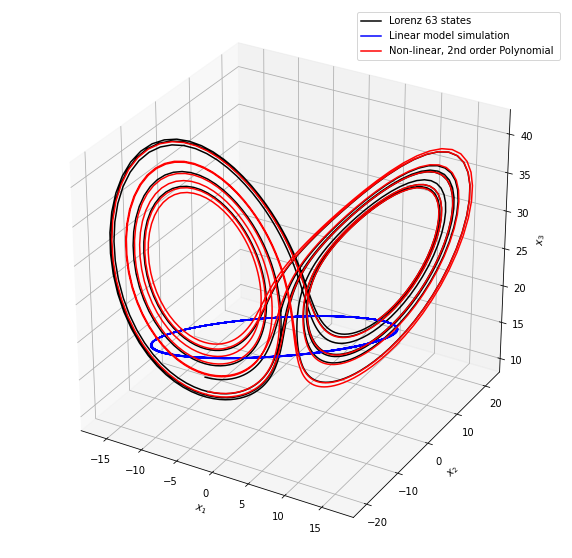

In [12]:
# plot
fig=plt.figure(figsize=(10,10))
ax=fig.gca(projection='3d')
line1,=ax.plot(xt.values[:1000,0],xt.values[:1000,1],xt.values[:1000,2],'k')
line2,=ax.plot(S_lin_Model[:1000,0],S_lin_Model[:1000,1],S_lin_Model[:1000,2],'b')
line3,=ax.plot(S_Poly2_Model[:1000,0],S_Poly2_Model[:1000,1],S_Poly2_Model[:1000,2],'r')

ax.set_xlabel('$x_1$');ax.set_ylabel('$x_2$');ax.set_zlabel('$x_3$')
plt.legend([line1,line2,line3], ['Lorenz 63 states', 'Linear model simulation', 'Non-linear, 2nd order Polynomial '])

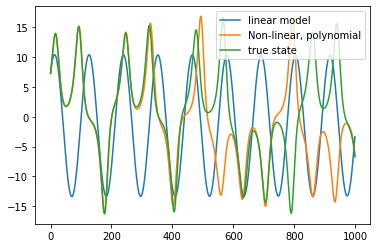

In [13]:
#" short term forecast : "
plt.plot(S_lin_Model[:1000,0],label ='linear model' )
plt.plot(S_Poly2_Model[:1000,0],label ='Non-linear, polynomial')
plt.plot(xt.values[:1000,0],label ='true state')
plt.legend()

## 2.3) Sparse identification of the dynamics !
The 2nd order polynomial model does a good job! this is due to the fact that the non-linearity present in the "unknown" Lorenz 63 equations is quadratic and is present in the dictionnary Poly({z}_{t}), making the inversion from the observations straightforward.

Bonus : including sparsity using threshholded least squares :

In [14]:
t_data       = np.arange(0,catalog.analogs.shape[0],1)*GD.dt_integration # needed in SINDy
data         = np.transpose(np.insert(np.array([catalog.analogs[:,0] , catalog.analogs[:,1] , catalog.analogs[:,2]]),0,t_data,axis=0))
ddata        = np.zeros([catalog.analogs.shape[0],catalog.analogs.shape[-1]+1])
ddata[:,1:]  = np.gradient(data[:,1:])[0]/GD.dt_integration

# Here sparsity_itterations is set to 10 sparse identification
# Polyorder  = 2 : 2nd order polynomial representation

sin = SINDy(data=data,polyorder=2,usesine=False,cutoff=0.02, sparsity_itterations = 10)
sin.SetDerivative(ddata)
sin.RunSINDy(simulate=False)

def Identified_Model(y,t, sin) :
    y=np.reshape(y,(1,y.shape[-1]))
    aug=sin.PoolData(y)    
    dy = np.dot(aug,sin._xi)
    return np.reshape(dy,(y.shape[-1]))

Initiated a class for Sparse Identification from Numerical Dynamics
**** Derivative Set ****
**** Candidate functions library has been created ****
**** Performing regression. Please wait... ****
Iteration in progress: 
1,
2,
3,
4,
5,
6,
7,
8,
9,
10,



In [15]:
init_cond   = xt.values[0,:]
end_time    = 10
S_Poly2_Model_sparse = odeint(Identified_Model,init_cond,np.arange(0.01,end_time+0.000001,GD.dt_integration),args=(sin,)); 

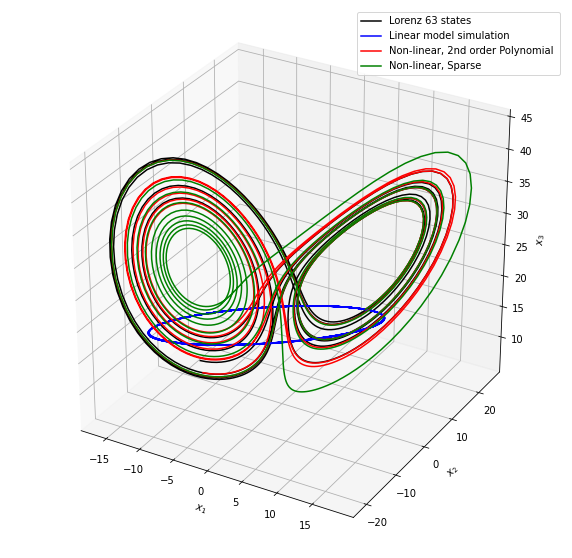

In [16]:
# plot
fig=plt.figure(figsize=(10,10))
ax=fig.gca(projection='3d')
line1,=ax.plot(xt.values[:1000,0],xt.values[:1000,1],xt.values[:1000,2],'k')
line2,=ax.plot(S_lin_Model[:1000,0],S_lin_Model[:1000,1],S_lin_Model[:1000,2],'b')
line3,=ax.plot(S_Poly2_Model[:1000,0],S_Poly2_Model[:1000,1],S_Poly2_Model[:1000,2],'r')
line4,=ax.plot(S_Poly2_Model_sparse[:1000,0],S_Poly2_Model_sparse[:1000,1],S_Poly2_Model_sparse[:1000,2],'g')

ax.set_xlabel('$x_1$');ax.set_ylabel('$x_2$');ax.set_zlabel('$x_3$')
plt.legend([line1,line2,line3,line4], ['Lorenz 63 states', 'Linear model simulation', 'Non-linear, 2nd order Polynomial ',  'Non-linear, Sparse '])

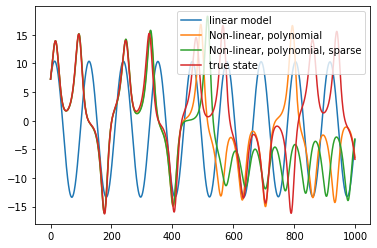

In [17]:
#" short term forecast : "
plt.plot(S_lin_Model[:1000,0],label ='linear model' )
plt.plot(S_Poly2_Model[:1000,0],label ='Non-linear, polynomial')
plt.plot(S_Poly2_Model_sparse[:1000,0],label ='Non-linear, polynomial, sparse')
plt.plot(xt.values[:1000,0],label ='true state')
plt.legend()

## 2.4 Question : Find the coefficients of the sparse regression and compare to the true model !

In [18]:
sin0._xi

array([[ 1.79308148e-03,  4.62765795e-01, -4.07798319e-01],
       [-1.01156875e+01,  2.77220663e+01, -3.12048739e-02],
       [ 1.00757679e+01, -9.09339740e-01,  2.38023072e-02],
       [ 1.00746576e-04, -5.50425719e-02, -2.57777391e+00],
       [ 4.11706443e-04, -5.81179940e-03,  2.75073356e-02],
       [-1.75888139e-04,  6.22789129e-03,  9.68560843e-01],
       [ 4.05699674e-03, -9.92137310e-01,  7.98393519e-04],
       [-1.15774670e-04, -1.78934106e-03,  7.95060229e-03],
       [-3.07731834e-03, -1.61275647e-03, -7.38120520e-04],
       [-4.75079678e-05,  1.46518700e-03, -3.32997023e-03]])

In [19]:
sin._xi

array([[ 0.        ,  0.        ,  0.        ],
       [-9.97767432, 27.80053738,  0.        ],
       [ 9.97767544, -0.96097517,  0.        ],
       [ 0.        ,  0.        , -2.658853  ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.99707011],
       [ 0.        , -0.99442307,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ]])

# 3) Limitations of regression techniques and neural representations 

Beyond the issus related to the prior parameterization of the dictionnary of non-linear terms, linear regression techiques fail when given noisy/partial observations of the state $z_t$ since the estimation of the derivatives become impossible. From this point of view, neural ODE models approximate the flowmap $\Phi_{\theta,t_n}({z}_{t_{n-1}}) = {z}_{t_{n-1}} + \int_{t_{n-1}}^{t_n}f_{\theta}({z}_{w})dw$ using a given integration routine. In order to highlight this aspect we consider the following case study with sparse in time data :

In [20]:
# dataset parameters
class GD:
    model = 'Lorenz_63'
    class parameters:
        sigma = 10.0
        rho = 28.0
        beta = 8.0/3
    dt_integration = 0.2 # sparse sampling time
    nb_loop_train = 800.01 #7500.1 # size of the catalog
    nb_loop_test = 100 # size of the true state and noisy observations
    sigma2_catalog = 0.0 # variance of the model error to generate the catalog
    
# run the data generation
catalog, xt = generate_data(GD)
# catalog is the true states zt, it containts a time sliced data base : 
# catalog.analogs    == zt
# catalog.successors == zt+n*dt_integration
# xt is the test set

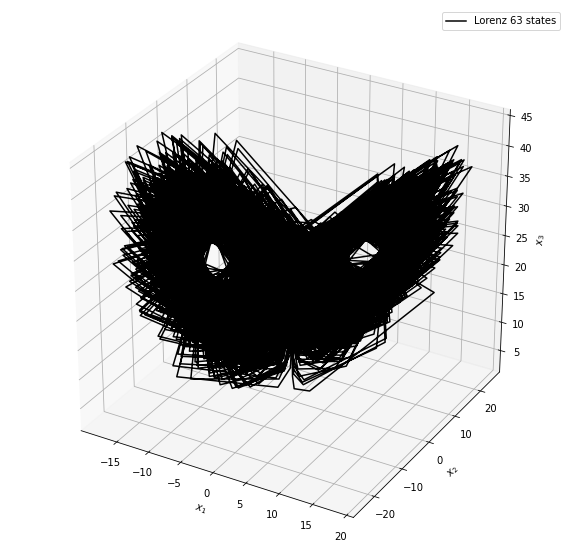

In [21]:
# plot
fig=plt.figure(figsize=(10,10))
ax=fig.gca(projection='3d')
line1,=ax.plot(catalog.analogs[:,0],catalog.analogs[:,1],catalog.analogs[:,2],'k')
ax.set_xlabel('$x_1$');ax.set_ylabel('$x_2$');ax.set_zlabel('$x_3$')
plt.legend([line1], ['Lorenz 63 states'])

In [22]:
t_data       = np.arange(0,catalog.analogs.shape[0],1)*GD.dt_integration # needed in SINDy
data         = np.transpose(np.insert(np.array([catalog.analogs[:,0] , catalog.analogs[:,1] , catalog.analogs[:,2]]),0,t_data,axis=0))
ddata        = np.zeros([catalog.analogs.shape[0],catalog.analogs.shape[-1]+1])
ddata[:,1:]  = np.gradient(data[:,1:])[0]/GD.dt_integration

# Here sparsity_itterations is set to 0 to mimic a classical least square optimization
# Polyorder  = 2 : 2nd order polynomial representation

sin = SINDy(data=data,polyorder=2,usesine=False,cutoff=0.02, sparsity_itterations = 10)
sin.SetDerivative(ddata)
sin.RunSINDy(simulate=False)

def Identified_Model(y,t, sin) :
    y=np.reshape(y,(1,y.shape[-1]))
    aug=sin.PoolData(y)    
    dy = np.dot(aug,sin._xi)
    return np.reshape(dy,(y.shape[-1]))

Initiated a class for Sparse Identification from Numerical Dynamics
**** Derivative Set ****
**** Candidate functions library has been created ****
**** Performing regression. Please wait... ****
Iteration in progress: 
1,
2,
3,
4,
5,
6,
7,
8,
9,
10,



In [23]:
init_cond   = xt.values[0,:]
end_time    = 100
S_Poly_sparse_data = odeint(Identified_Model,init_cond,np.arange(0.01,end_time+0.000001,GD.dt_integration),args=(sin,)); 

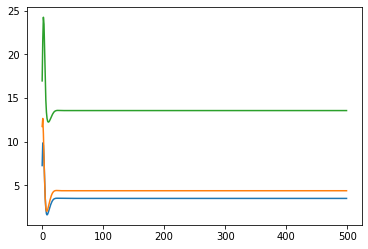

In [24]:
plt.plot(S_Poly_sparse_data)

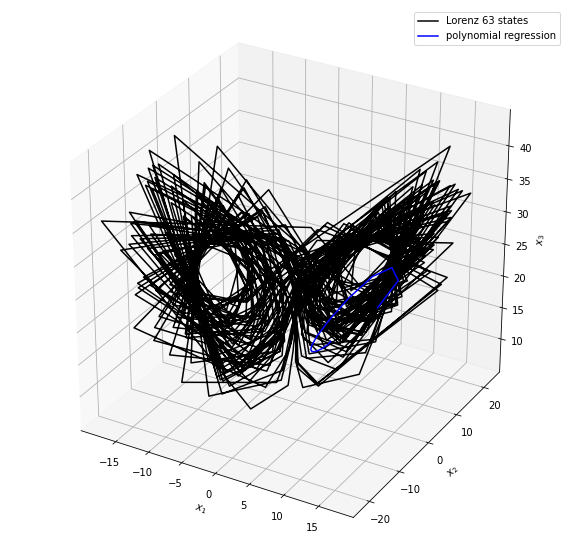

In [25]:
# plot
fig=plt.figure(figsize=(10,10))
ax=fig.gca(projection='3d')
line1,=ax.plot(xt.values[:1000,0],xt.values[:1000,1],xt.values[:1000,2],'k')
line2,=ax.plot(S_Poly_sparse_data[:1000,0],S_Poly_sparse_data[:1000,1],S_Poly_sparse_data[:1000,2],'b')

ax.set_xlabel('$x_1$');ax.set_ylabel('$x_2$');ax.set_zlabel('$x_3$')
plt.legend([line1,line2], ['Lorenz 63 states', 'polynomial regression'])

# 4) Neural ODE 
Even with the correct non-linearity, the linear regression technique can not work since the estimation of the derivatives is impossible given such sparse data. Two solutions are possible, the forst one is using a neural ODE model with an adaptive step size solver, or jointly learning the ODE model and the integration operator.

## 4.1) NODE model with fixed stepsize solver : RK4 
Here we consider the following problem:
\begin{equation}
\left \{
\begin{array}{ccl}
\dot{{z}_{t}} &=& {f_{\theta}}({z}_{t})\\
\Phi_{\theta,t_n}({z}_{t_{n-1}}) &=& {z}_{t_{n-1}} + \int_{t_{n-1}}^{t_n}f_{\theta}({z}_{w})dw
\label{eq:C2_dm_SSM_identity}
\end{array}\right.
\end{equation}

Where $f_{\theta}$ is a neural network and $\Phi$ the Runge Kutta 4 solver. Overall, the parameters of $f_{\theta}$ are optimized based on minimizing a forecasting cost of the following form:
\begin{equation}
    \displaystyle \min_{\theta} \sum_{n=1}^N \| {z}_{t_{n}} - \Phi_{\theta,t_n}({z}_{t_{n-1}})\| 
    \label{eq:opti_case_Identity}
\end{equation}

In [26]:
from torchdiffeq import odeint as odeintTorch

In [28]:
device = 'cuda:0'
params = {}#NN parameters 
params['nb_batch']=20
params['batch_size']=int(catalog.analogs.shape[0]/params['nb_batch'])
params['transition_layers']=1
params['bi_linear_layers']=3
params['dim_hidden_linear'] = 3
params['dim_input']=3
params['dim_observations'] = 3
params['dim_output']=3
params['dim_hidden']=3
params['dt_integration']=GD.dt_integration
params['ntrain']=[10000]
params['pretrained']=True
params['path']='NODE_RK4_Lorend_dt_02'
params['lr']=0.001

In [29]:
class NODE_model(torch.nn.Module):
        def __init__(self, params):
            super(NODE_model, self).__init__()
            self.linearCell   = torch.nn.Linear(params['dim_input'], params['dim_hidden_linear']).to(device) 
            self.BlinearCell1 = torch.nn.ModuleList([torch.nn.Linear(params['dim_input'], 1).to(device) for i in range(params['bi_linear_layers'])])
            self.BlinearCell2 = torch.nn.ModuleList([torch.nn.Linear(params['dim_input'], 1).to(device) for i in range(params['bi_linear_layers'])])
            augmented_size    = params['bi_linear_layers'] + params['dim_hidden_linear']
            self.transLayers = torch.nn.ModuleList([torch.nn.Linear(augmented_size, params['dim_output']).to(device)])
            self.transLayers.extend([torch.nn.Linear(params['dim_output'], params['dim_output']).to(device) for i in range(1, params['transition_layers'])])
            self.outputLayer  = torch.nn.Linear(params['dim_output'], params['dim_output']).to(device)
        def forward(self,dt, inp):
            """
            In the forward function we accept a Tensor of input data and we must return
            a Tensor of output data. We can use Modules defined in the constructor as
            well as arbitrary operators on Tensors.
            """
            BP_outp = (torch.zeros((inp.size()[0],params['bi_linear_layers'])).to(device))
            L_outp   = self.linearCell(inp)
            for i in range((params['bi_linear_layers'])):
                BP_outp[:,i]=self.BlinearCell1[i](inp)[:,0]*self.BlinearCell2[i](inp)[:,0]
            aug_vect = torch.cat((L_outp, BP_outp), dim=1)
            for i in range((params['transition_layers'])):
                aug_vect = (self.transLayers[i](aug_vect))
            grad = self.outputLayer(aug_vect)
            return grad
model  = NODE_model(params).to(device)

In [30]:
x = (torch.from_numpy(catalog.analogs).float().to(device).reshape(params['nb_batch'],params['batch_size'],-1))
y = (torch.from_numpy(catalog.successors).float().to(device).reshape(params['nb_batch'],params['batch_size'],-1))
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

dt = GD.dt_integration*np.arange(x.shape[1])
dt = torch.from_numpy(dt).float().to(device)
time  = dt[:2]

In [31]:
if params['pretrained'] :
    model.load_state_dict(torch.load(params['path']+'.pt'))
else:
    print ('Learning dynamical model')
    for t in tqdm(range(params['ntrain'][0])):
            for b in range(x.shape[0]):
                # Forward pass: Compute predicted gradients by passing x to the model
                pred = odeintTorch(model, x[b,:,:], time, method='rk4')#modelRINN(x[b,:,:],params['dt_integration'],order)
                loss = criterion(pred[1,:,:], y[b,:,:])
                # Zero gradients, perform a backward pass, and update the weights.
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            torch.save(model.state_dict(), params['path']+'.pt')
    print(t,loss)

In [32]:
dt_test     = GD.dt_integration*np.arange(xt.values.shape[0])
dt_test     = torch.from_numpy(dt_test).float().to(device)
init_cond   = (torch.from_numpy(xt.values[:1,:]).float().to(device))
S_NODE_RK4  = odeintTorch(model, init_cond, dt, method='rk4')

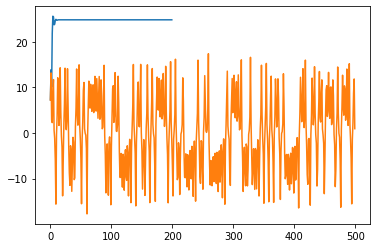

In [33]:
plt.plot(S_NODE_RK4.cpu().detach()[:,0,0])
plt.plot(xt.values[:,0])

## 4.2) Neural ODE with adaptive stepsize solver 

Here we consider the following problem:
\begin{equation}
\left \{
\begin{array}{ccl}
\dot{{z}_{t}} &=& {f_{\theta}}({z}_{t})\\
\Phi_{\theta,t_n}({z}_{t_{n-1}}) &=& {z}_{t_{n-1}} + \int_{t_{n-1}}^{t_n}f_{\theta}({z}_{w})dw
\label{eq:C2_dm_SSM_identity}
\end{array}\right.
\end{equation}

Where $f_{\theta}$ is a neural network and $\Phi$ is an adaptive stepsize solver. As seen above, fixed step size solvers such as Runge-Kutta 4 or Euler can have large truncation errors, making the identifiability impossible when given temporally sparse data, such integration techniques . Overall, the parameters of $f_{\theta}$ are optimized based on minimizing a forecasting cost of the following form:
\begin{equation}
    \displaystyle \min_{\theta} \sum_{n=1}^N \| {z}_{t_{n}} - \Phi_{\theta,t_n}({z}_{t_{n-1}})\| 
    \label{eq:opti_case_Identity}
\end{equation}

In [34]:
params['ntrain']=[300]
params['pretrained']=True
params['path']='NODE_Adaptive_Step_Size_Lorenz_dt_02'

In [35]:
if params['pretrained'] :
    model.load_state_dict(torch.load(params['path']+'.pt'))
else:
    print ('Learning dynamical model')
    for t in tqdm(range(params['ntrain'][0])):
            for b in range(x.shape[0]):
                # Forward pass: Compute predicted gradients by passing x to the model
                pred = odeintTorch(model, x[b,:,:], time, method='dopri8')
                loss = criterion(pred[1,:,:], y[b,:,:])
                # Zero gradients, perform a backward pass, and update the weights.
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            torch.save(model.state_dict(), params['path']+'.pt')
    print(t,loss)

In [36]:
dt_test     = GD.dt_integration*np.arange(xt.values.shape[0])
dt_test     = torch.from_numpy(dt_test).float().to(device)
init_cond   = (torch.from_numpy(xt.values[:1,:]).float().to(device))
S_NODE_Adap = odeintTorch(model, init_cond, dt, method='dopri8')

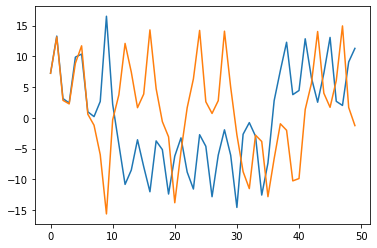

In [37]:
plt.plot(S_NODE_Adap.cpu().detach()[:50,0,0])
plt.plot(xt.values[:50,0])

## 4.3) Neural ODE with trainable integration scheme 

We first define a parameterization of the data-driven ODE
\begin{equation}
     \dot{{z}}_{t} = f_{\theta_{NN}}(t,{z}_{t})
     \label{EQ:sec3_ODE_eq_DD}
\end{equation}
in a differentiable framework, which usually corresponds to the definition of a neural network architecture with parameters $\theta_{NN}$. This archictecture may rely on physics-informed parameterizations or  on fully data-driven formulations. Regarding the numerical integration of the ODE, we aim to apply a trainable  $q$-stage Runge-Kutta scheme $\mathcal{ADRK}_q$. 

Here, we aim to jointly learn the parameters of the ADRK integration scheme as well as of the ODE, such that the set of trainable parameters $\Theta$ are given by
\begin{equation}
\label{EQ:trainable_params_DD}
\begin{split}
\Theta &= \{\mathcal{ADRK}_q, \theta_{NN} \}
\end{split}
\end{equation}

Similarly to the previous case-study, the training procedure comes to optimize all trainable parameters with a view to minimizing the forecasting error from a predefined initial condition, which leads to the following training loss:
\begin{equation}
\label{EQ:cost_function_DD}
\begin{split}
\mathcal{L}(\Theta) &= \displaystyle \sum_{n=1}^N \| {z}_{t_{n}} - \Phi_{\mathcal{ADRK}_q,\theta_{NN},t_n}({z}_{t_{n-1}})\|  
\end{split}
\end{equation}
with $\Phi_{\mathcal{ADRK}_q,\theta_{NN},t_n}({z}_{t_{n-1}})$ the numerical ADRK integration of of the NODE model.

In [40]:
device = 'cuda:0'
params_ADRK = {}#NN parameters 
params_ADRK['transition_layers']=1
params_ADRK['bi_linear_layers']=3
params_ADRK['dim_hidden_linear'] = 3
params_ADRK['dim_input']=3
params_ADRK['dim_observations'] = 3
params_ADRK['dim_output']=3
params_ADRK['dim_hidden']=3
params_ADRK['dt_integration']=GD.dt_integration
params_ADRK['ntrain']=[2000]
params_ADRK['pretrained']=True
params_ADRK['nb_stages'] = 11
params_ADRK['path']='ADRK_Lorenz_dt_02'

In [41]:
class applyRK_Constraints(object):
        def __init__(self, frequency=1):
            self.frequency = frequency
    
        def __call__(self, module):
            if hasattr(module, 'b'):
                module.b.data = (torch.abs(module.b.data))
                module.b.data  =  ((module.b.data) / (module.b.data).sum(1,keepdim = True).expand_as(module.b.data))
            if hasattr(module, 'c'):
                module.c.data = module.c.data
                module.c.data[:,0] = 0
                module.c.data = module.c.data.sub_(torch.min(module.c.data)).div_(torch.max(module.c.data) - torch.min(module.c.data)).sort()[0]
                

class NODE_model_ADRK(torch.nn.Module):
        def __init__(self, params):
            super(NODE_model_ADRK, self).__init__()
            self.linearCell   = torch.nn.Linear(params_ADRK['dim_input'], params_ADRK['dim_hidden_linear']).to(device) 
            self.BlinearCell1 = torch.nn.ModuleList([torch.nn.Linear(params_ADRK['dim_input'], 1).to(device) for i in range(params_ADRK['bi_linear_layers'])])
            self.BlinearCell2 = torch.nn.ModuleList([torch.nn.Linear(params_ADRK['dim_input'], 1).to(device) for i in range(params_ADRK['bi_linear_layers'])])
            augmented_size    = params_ADRK['bi_linear_layers'] + params_ADRK['dim_hidden_linear']
            self.transLayers = torch.nn.ModuleList([torch.nn.Linear(augmented_size, params_ADRK['dim_output']).to(device)])
            self.transLayers.extend([torch.nn.Linear(params_ADRK['dim_output'], params_ADRK['dim_output']).to(device) for i in range(1, params_ADRK['transition_layers'])])
            self.outputLayer  = torch.nn.Linear(params_ADRK['dim_output'], params_ADRK['dim_output']).to(device)
        def forward(self, inp):
            BP_outp = (torch.zeros((inp.size()[0],params_ADRK['bi_linear_layers'])).to(device))
            L_outp   = self.linearCell(inp)
            for i in range((params_ADRK['bi_linear_layers'])):
                BP_outp[:,i]=self.BlinearCell1[i](inp)[:,0]*self.BlinearCell2[i](inp)[:,0]
            aug_vect = torch.cat((L_outp, BP_outp), dim=1)
            for i in range((params_ADRK['transition_layers'])):
                aug_vect = (self.transLayers[i](aug_vect))
            grad = self.outputLayer(aug_vect)
            return grad
model  = NODE_model_ADRK(params).to(device)

class INT_net(torch.nn.Module):
        def __init__(self, params,order):
            super(INT_net, self).__init__()
            self.Dyn_net = model
            a = 0.*np.tril(np.random.uniform(size=(1,order,order)),k=-1)
            b = 0.*np.random.uniform(size=(1,order))
            c = 0.01*np.random.uniform(size=(1,order))
            self.a = torch.nn.Parameter(torch.from_numpy(a[:,:,:]).float().to(device),requires_grad = True).to(device)
            self.b = torch.nn.Parameter(torch.from_numpy(b).float().to(device),requires_grad = True).to(device)
            self.c = torch.nn.Parameter(torch.from_numpy(c).float().to(device),requires_grad = True).to(device)
         
        def forward(self, inp, dt, order):
            """
            In the forward function we accept a Tensor of input data and we must return
            a Tensor of output data. We can use Modules defined in the constructor as
            well as arbitrary operators on Tensors.
            """
            k = [(self.Dyn_net(inp))]
            for i in range(1,order):
                coef_sum = torch.autograd.Variable(torch.zeros(k[0].size()).to(device))
                for j in range(0,i):
                    if j ==0:
                        if i == 1:
                            coef_sum = coef_sum + k[j]*(self.c[:,i]).expand_as(k[j])
                        else:
                            coef_sum = coef_sum + k[j]*(self.c[:,i]-self.a[:,i,1:i].sum(1)).expand_as(k[j])
                    else :
                        coef_sum = coef_sum + k[j]*self.a[:,i,j].expand_as(k[j])
                rk_inp = inp+dt*coef_sum        
                k.append(self.Dyn_net(rk_inp))
            pred_sum = torch.autograd.Variable(torch.zeros(k[0].size()).to(device))
            for i in range(0,order): 
                pred_sum = pred_sum+k[i]*self.b[:,i].expand_as(k[i])
            pred = inp +dt*pred_sum
            return pred ,k[0], inp

In [42]:
flow_map = INT_net(params,params_ADRK['nb_stages']).to(device)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(flow_map.parameters(), lr = 0.01)

In [43]:
if params_ADRK['pretrained'] :
    flow_map.load_state_dict(torch.load(params_ADRK['path']+'.pt'))
else:
    clipper = applyRK_Constraints()
    print ('Learning dynamical model')
    for t in tqdm(range(params_ADRK['ntrain'][0])):
            for b in range(x.shape[0]):
                # Forward pass: Compute predicted gradients by passing x to the model
                pred ,grad , inp = flow_map(x[b,:,:],params_ADRK['dt_integration'],params_ADRK['nb_stages'])
                # Compute and print loss
                loss = criterion(pred, y[b,:,:])
                if not False:
                    # Zero gradients, perform a backward pass, and update the weights.
                    optimizer.zero_grad() 
                    loss.backward()
                    optimizer.step()
                    #torch.nn.utils.clip_grad_norm_(modelRINN.parameters(),5)
                    #for p in modelRINN.parameters():
                    #    p.register_hook(lambda grad: torch.clamp(grad, -clip_value, clip_value))
                    #modelRINN.apply(clipper)
                    torch.save(flow_map.state_dict(), params_ADRK['path']+'.pt')
                    if t % clipper.frequency == 0:
                        flow_map.apply(clipper)
    print(t,loss.detach().numpy())

In [44]:
nb_steps_pred = xt.values.shape[0]
t_pred = nb_steps_pred * params_ADRK['dt_integration']
S_NODE_ADRK = [torch.from_numpy(xt.values[:1,:]).float().to(device)]
for i in range(1,nb_steps_pred):
    S_NODE_ADRK.append(flow_map(S_NODE_ADRK[-1],params_ADRK['dt_integration'],params_ADRK['nb_stages'])[0])
S_NODE_ADRK = torch.stack(S_NODE_ADRK)

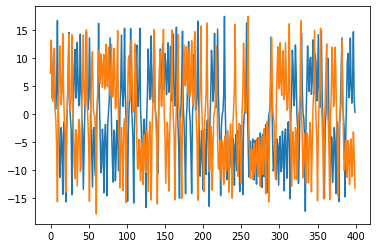

In [45]:
plt.plot(S_NODE_ADRK.cpu().detach()[:400,0,0])
plt.plot(xt.values[:400,0])

/usr/local/lib/python3.7/dist-packages/mpl_toolkits/mplot3d/proj3d.py:189: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array([xs, ys, zs, np.ones_like(xs)])


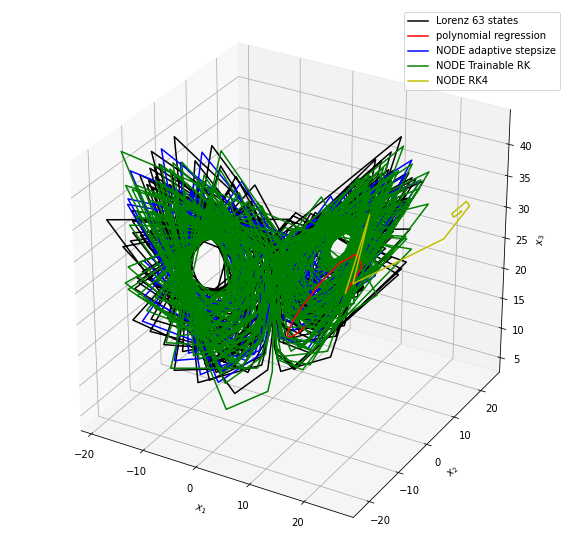

In [46]:
# plot
fig=plt.figure(figsize=(10,10))
ax=fig.gca(projection='3d')
line1,=ax.plot(xt.values[:,0],xt.values[:,1],xt.values[:,2],'k')
line3,=ax.plot(S_NODE_Adap.cpu().detach()[:,0,0],S_NODE_Adap.cpu().detach()[:,0,1],S_NODE_Adap.cpu().detach()[:,0,2],'b')
line4,=ax.plot(S_NODE_ADRK.cpu().detach()[:,0,0],S_NODE_ADRK.cpu().detach()[:,0,1],S_NODE_ADRK.cpu().detach()[:,0,2],'g')
line2,=ax.plot(S_Poly_sparse_data[:,0],S_Poly_sparse_data[:,1],S_Poly_sparse_data[:,2],'r')
line5,=ax.plot(S_NODE_RK4.cpu().detach()[:,0,0],S_NODE_RK4.cpu().detach()[:,0,1],S_NODE_RK4.cpu().detach()[:,0,2],'y')

ax.set_xlabel('$x_1$');ax.set_ylabel('$x_2$');ax.set_zlabel('$x_3$')
plt.legend([line1,line2,line3,line4,line5], ['Lorenz 63 states', 'polynomial regression', 'NODE adaptive stepsize', 'NODE Trainable RK', 'NODE RK4'])

# FUN : Stability analysis of the trained integration scheme

In [47]:
#extracting integration scheme params
a=flow_map.a.clone().cpu().data.numpy()[0,:,:]
b=flow_map.b.clone().cpu().data.numpy()[0,:]
c=flow_map.c.clone().cpu().data.numpy()[0,:]

a[:,0] = c[:] - a[:,:].sum(axis = 1)

In [48]:
rz = np.arange(-10,10+0.000001,0.01)
iz = np.arange(-10,10+0.000001,0.01)
rz, iz = np.meshgrid(rz,iz)
z  = rz+iz*1.j

In [49]:
GRINN = np.zeros_like(z)*np.nan
list_g = []
list_x = []
list_y = []
for i in tqdm(range(z.shape[0])):
    for j in range(z.shape[1]):
        tmp = np.abs(1+z[i,j]*np.dot(np.dot(b.T,np.linalg.inv(np.eye(a.shape[0])-z[i,j]*a)),np.ones_like(b)))
        if tmp<1:
            GRINN[i,j] = np.abs(1+z[i,j]*np.dot(np.dot(b.T,np.linalg.inv(np.eye(a.shape[0])-z[i,j]*a)),np.ones_like(b)))
            list_g.append(GRINN[i,j].real)
            list_x.append(z[i,j].real)
            list_y.append(z[i,j].imag)

100%|██████████| 2001/2001 [09:43<00:00,  3.43it/s]


In [50]:
GE = np.zeros_like(z)*np.nan
list_gE = []
list_xE = []
list_yE = []
for i in tqdm(range(z.shape[0])):
    for j in range(z.shape[1]):
        tmp = np.abs(1+z[i,j])
        if tmp<1:
            GE[i,j] = tmp
            list_gE.append(GE[i,j].real)
            list_xE.append(z[i,j].real)
            list_yE.append(z[i,j].imag)

100%|██████████| 2001/2001 [00:12<00:00, 157.83it/s]


In [51]:
GRK4 = np.zeros_like(z)*np.nan
ark4 = np.array([[0,0,0,0],[1/2,0,0,0],[0,1/2,0,0],[0,0,1,0]])
brk4 = np.array([1/6,1/3,1/3,1/6])

list_gRK4 = []
list_xRK4 = []
list_yRK4 = []
for i in tqdm(range(z.shape[0])):
    for j in range(z.shape[1]):
        tmp = np.abs(1+z[i,j]*np.dot(np.dot(brk4.T,np.linalg.inv(np.eye(ark4.shape[0])-z[i,j]*ark4)),np.ones_like(brk4)))
        if tmp<1:
            GRK4[i,j] = tmp
            list_gRK4.append(GRK4[i,j].real)
            list_xRK4.append(z[i,j].real)
            list_yRK4.append(z[i,j].imag)

100%|██████████| 2001/2001 [06:13<00:00,  5.36it/s]


In [58]:
plt.rcParams.update({
    "text.usetex": False})

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
/usr/local/lib/python3.7/dist-packages/google/colab/_event_manager.py:28: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/IPython/core/pylabtools.py:125: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


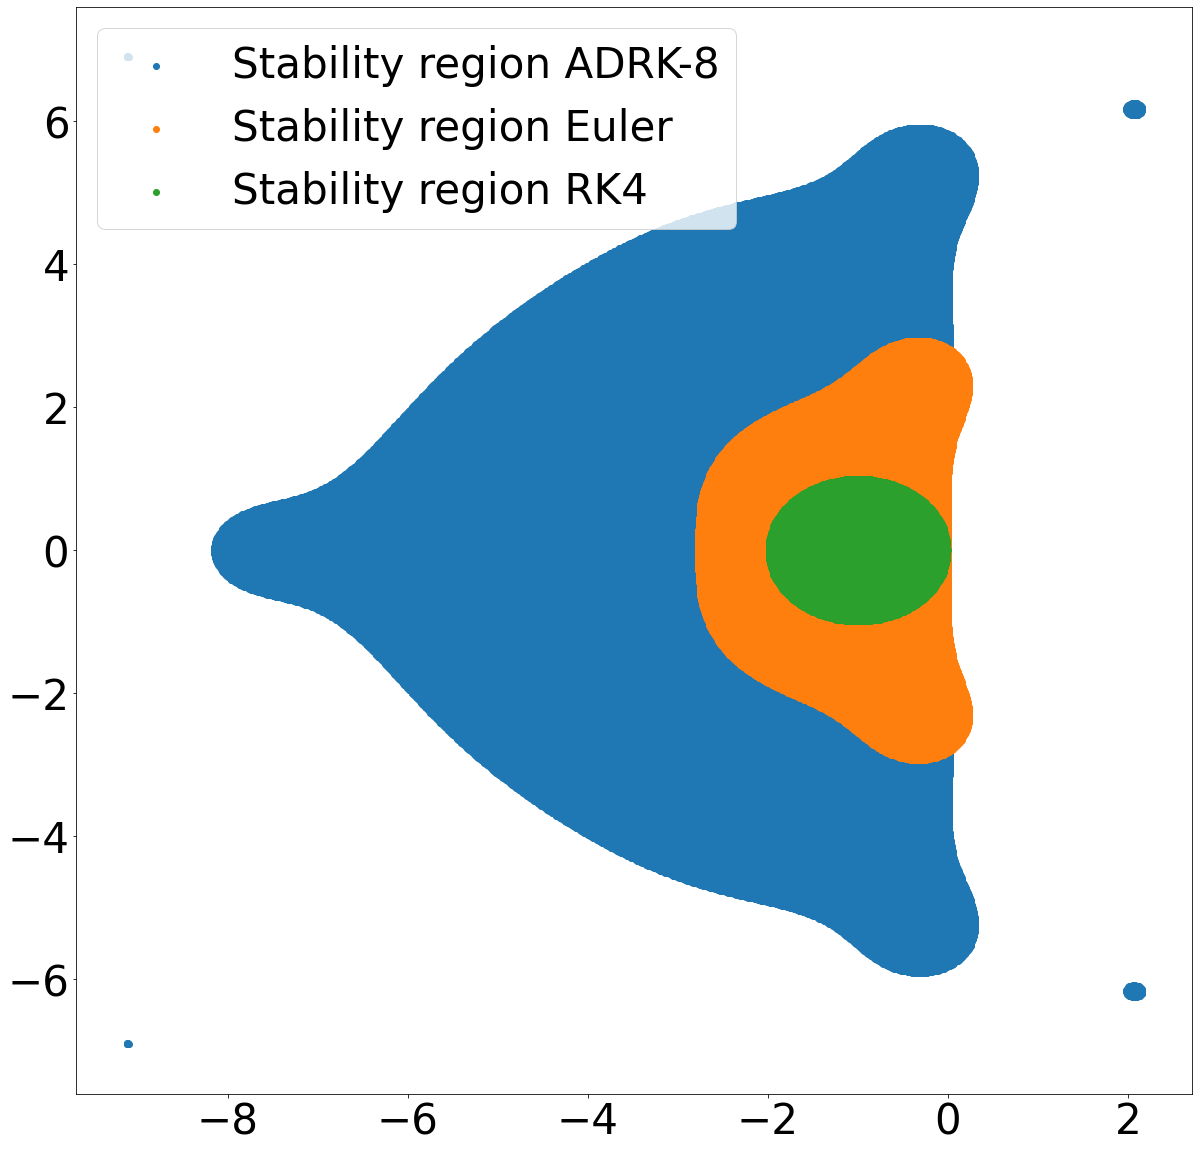

In [59]:
plt.figure(figsize=(20,20))
plt.scatter(np.array(list_x),np.array(list_y),label = 'Stability region ADRK-8')
plt.scatter(np.array(list_xRK4),np.array(list_yRK4),label = 'Stability region Euler')
plt.scatter(np.array(list_xE),np.array(list_yE),label = 'Stability region RK4')


plt.legend()